In [1]:
import numpy as np
import pandas as pd
import queue
import threading
from os import listdir
from stats import *
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm,LogNorm
import matplotlib.cm as cm

Load in all of the saved histograms.

In [2]:
XY_hist_12hz = Histogram.from_file("HIST_X_Y12hz23.pkl")
XY_hist_22hz = Histogram.from_file("HIST_X_Y22hz23.pkl")
XY_hist_30hz = Histogram.from_file("HIST_X_Y30hz23.pkl")

theta_hist_12hz = Histogram.from_file("HIST_Orientation12hz23.pkl")
theta_hist_22hz = Histogram.from_file("HIST_Orientation22hz23.pkl")
theta_hist_30hz = Histogram.from_file("HIST_Orientation30hz23.pkl")

z_hist_12hz = Histogram.from_file("HIST_Layer12hz23.pkl")
z_hist_22hz = Histogram.from_file("HIST_Layer22hz23.pkl")
z_hist_30hz = Histogram.from_file("HIST_Layer30hz23.pkl")

Plotting functions

In [3]:
def calc_plot_range(*data_vals,non_zero=False):
    min_ = np.inf
    max_ = -np.inf
    for values in data_vals:
        new_min = np.ma.masked_equal(values,0.0,copy=True).min() if non_zero else values.min()
        new_max = values.max()
        max_ = new_max if new_max > max_ else max_
        min_ = new_min if new_min < min_ else min_
    oom = np.floor(np.log10(max_ - min_))
    return 10**oom * np.floor(min_/10**oom), 10**oom * np.ceil(max_/10**oom)

In [4]:
def calc_colour_range(*data_vals,non_zero=True):
    min_ = np.inf
    max_ = -np.inf
    for values in data_vals:
        new_min = np.ma.masked_equal(values,0.0,copy=True).min() if non_zero else values.min()
        new_max = values.max()
        max_ = new_max if new_max > max_ else max_
        min_ = new_min if new_min < min_ else min_
    return min_,max_

In [5]:
def quick_plot_comparison(fig,axs,variable,*histograms):
    means = []
    stds = []
    for i,histogram in enumerate(histograms):
        index = histogram.variable_names.index(variable)
        bin_width = (histogram.bin_coords[0][1:] - histogram.bin_coords[0][:-1]).min() * 1.0
        # Mean
        mean = np.divide(histogram.sums[index,:],histogram.counts[index,:],out=np.zeros_like(histogram.sums[index,:]),where=histogram.counts[index,:]>0)
        means.append(mean)
        axs[0][i].bar(
            0.5*(histogram.bin_coords[0][1:] + histogram.bin_coords[0][:-1]),
            mean,
            width = bin_width
        )

        # Std 
        std = np.sqrt(
            np.divide(histogram.sum2[index,:],histogram.counts[index,:],out=np.zeros_like(histogram.sum2[index,:]),where=histogram.counts[index,:]>0) -\
                mean**2)
        stds.append(std)
        axs[1][i].bar(
            0.5*(histogram.bin_coords[0][1:] + histogram.bin_coords[0][:-1]),
            std,
            width = bin_width
        )

        # Count
        axs[2][i].bar(
            0.5*(histogram.bin_coords[0][1:] + histogram.bin_coords[0][:-1]),
            histogram.counts[index,:],
            width = bin_width
        )
        # Common x-axis
        axs[2][i].set_xticks(histogram.bin_coords[0]) 
        
    # Label and rescale y-axis.
    axs[0][0].set_ylabel("Mean {} value".format(variable))
    axs[0][0].set_ylim(*calc_plot_range(*means))


    axs[1][0].set_ylabel("{} value std".format(variable))
    axs[1][0].set_ylim(*calc_plot_range(*stds))
        
    axs[2][0].set_ylabel("{} value count".format(variable))

In [6]:
def quick_plot_2d(fig,axs,variable,*histograms):
    means = []
    stds = []
    counts = []
    for i,histogram in enumerate(histograms):
        index = histogram.variable_names.index(variable)
        # Mean
        mean = np.divide(histogram.sums[index,:],histogram.counts[index,:],out=np.zeros_like(histogram.sums[index,:]),where=histogram.counts[index,:]>0)
        means.append(mean)

        # Std 
        std = np.sqrt(
            np.divide(histogram.sum2[index,:],histogram.counts[index,:],out=np.zeros_like(histogram.sum2[index,:]),where=histogram.counts[index,:]>0) -\
                mean**2)
        stds.append(std)
        
        # Count
        counts.append(histogram.counts[index,:])
        
    # Calculate colour ranges
    std_min,std_max = calc_colour_range(*stds,non_zero=True)
    mean_min,mean_max = calc_colour_range(*means,non_zero=True)
    count_min,count_max = calc_colour_range(*counts,non_zero=True)

    # Repeat loop
    for i,histogram in enumerate(histograms):
        # Mean
        mean = means[i]
        axs[0][i].imshow(mean.reshape(len(histogram.bin_coords[0])-1,len(histogram.bin_coords[1])-1),
                         cmap="afmhot_r",
                         norm=LogNorm(mean_min,mean_max,clip=True),
                         interpolation='none',
                         origin='lower')

        # Std 
        std = stds[i]
        axs[1][i].imshow(std.reshape(len(histogram.bin_coords[0])-1,len(histogram.bin_coords[1])-1),
                         cmap="afmhot_r",
                         norm=LogNorm(std_min,std_max,clip=True),
                         interpolation='none',
                         origin='lower')

        # Count
        axs[2][i].imshow(histogram.counts[index,:].reshape(len(histogram.bin_coords[0])-1,len(histogram.bin_coords[1])-1),
                         cmap="afmhot_r",
                         norm=LogNorm(count_min,count_max,clip=True),
                         interpolation='none',
                         origin='lower')
        # Common axes
        # axs[2][i].set_xticks(histogram.bin_coords[0]) 
        # axs[2][i].set_yticks(histogram.bin_coords[1])
    
    return stds,means,counts

In [7]:
def plot_health(fig,variable,xy_plane_hist=None,theta_hist=None,z_hist=None,quantity="mean"):
    # Function used to calculate the plot quantity. 
    if callable(quantity):
        func_ = quantity
    elif quantity == "mean":
        func_ = lambda histogram,index: np.divide(histogram.sums[index,:],histogram.counts[index,:],out=np.zeros_like(histogram.sums[index,:]),where=histogram.counts[index,:]>0)
    elif quantity == "std":
        func_ = lambda histogram,index: np.sqrt(
            np.divide(histogram.sum2[index,:],histogram.counts[index,:],out=np.zeros_like(histogram.sum2[index,:]),where=histogram.counts[index,:]>0) -\
                np.divide(histogram.sums[index,:],histogram.counts[index,:],out=np.zeros_like(histogram.sums[index,:]),where=histogram.counts[index,:]>0) **2 )
    elif quantity == "count":
        func_ = lambda histogram,index: histogram.counts[index,:]
    else:
        raise ValueError("quantity arg should be 'mean', 'std', 'count' or a callable.")
    
    num_axes = sum([0 if hist is None else w for hist,w in zip((xy_plane_hist,theta_hist,z_hist),(1,2,2))])
    ax_ind = 1
    
    # Z-histogram
    if z_hist is not None:
        ax_z = fig.add_subplot(1,num_axes,ax_ind)
        index = z_hist.variable_names.index(variable)
        values = func_(z_hist,index)
        # Make plot
        ax_z.barh(0.5*(z_hist.bin_coords[0][1:] + z_hist.bin_coords[0][:-1]),
            values,
            z_hist.bin_coords[0][1:] - z_hist.bin_coords[0][:-1],
            color='orange'
        )
        ax_z.set_ylabel("layer number")
        ax_z.set_xlim(*calc_plot_range(values))
        ax_z.set_ylim(z_hist.bin_coords[0][0],z_hist.bin_coords[0][-1])
        
        ax_ind += 1
    else:
        ax_z = None
    
    # XY planar heatmap
    if xy_plane_hist is not None:
        ax_xy = fig.add_subplot(1,num_axes,(ax_ind,ax_ind+1))
        index = xy_plane_hist.variable_names.index(variable)
        values = func_(xy_plane_hist,index)
        # Make plot
        ax_xy.imshow(values.reshape(len(xy_plane_hist.bin_coords[0])-1,len(xy_plane_hist.bin_coords[1])-1),
                         cmap="afmhot_r",
                         norm=LogNorm(*calc_colour_range(values,non_zero=True),clip=True),
                         interpolation='none',
                         origin='lower')
        ax_xy.set_xlabel("x coordinate")
        ax_xy.set_ylabel("y coordinate")
        
        ax_ind += 2
    else:
        ax_xy = None
    
    # Orientation histogram
    if theta_hist is not None:
        # Some plotting parameters
        bot = 30.0
        top = 100.0
        
        ax_th = fig.add_subplot(1,num_axes,(ax_ind,ax_ind+1),polar=True)
        index = theta_hist.variable_names.index(variable)
        values = func_(theta_hist,index)
        min_,max_ = calc_plot_range(values)
        # Make plot 
        ax_th.bar(0.5*(theta_hist.bin_coords[0][1:] + theta_hist.bin_coords[0][:-1]),
            bot + (top-bot) * (values - min_)/(max_ - min_),
            width = theta_hist.bin_coords[0][1:] - theta_hist.bin_coords[0][:-1],
            bottom = bot,
            color='orange'
        )
        ax_th.set_rticks([bot,0.5*(bot+top),top],labels=[min_,0.5*(min_+max_),max_])
        
        ax_ind += 2
    else:
        ax_th = None
    
    return ax_z,ax_xy,ax_th

## Plots

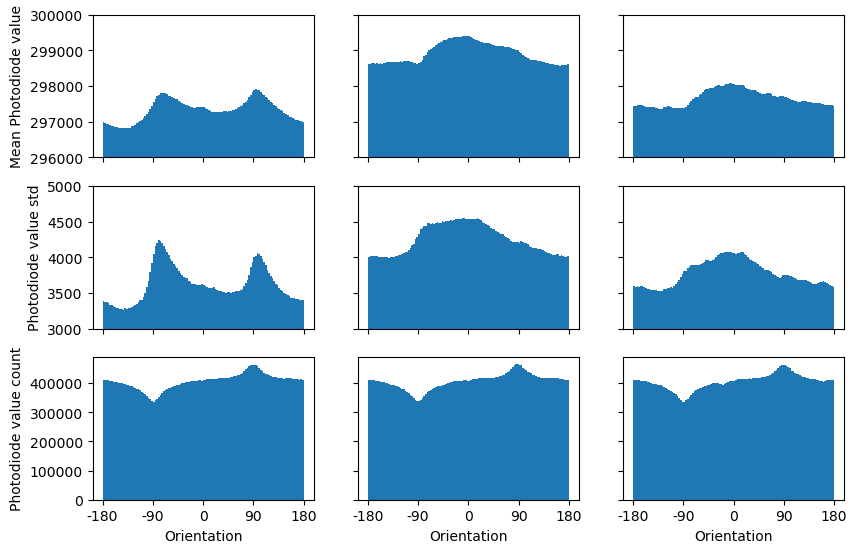

In [8]:
fig,axs = plt.subplots(nrows=3,ncols=3,sharex=True,sharey="row",figsize=(9.7,6.3))
quick_plot_comparison(fig,axs,"Photodiode",theta_hist_12hz,theta_hist_22hz,theta_hist_30hz)
#custom
for i in range(3):
    axs[2][i].set_xlabel("Orientation")
axs[2][0].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
axs[2][0].set_xticklabels([-180,-90,0,90,180]) ;

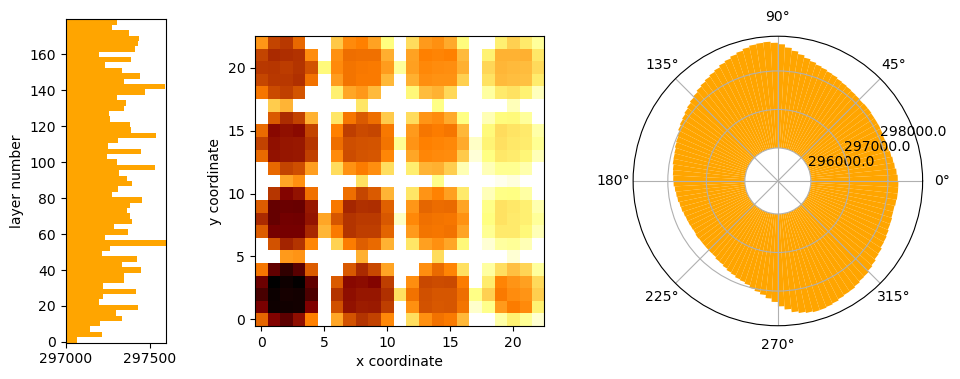

In [9]:
fig = plt.figure(figsize=(9.7,4.0))
plot_health(fig,
            "Photodiode",
            #"Spatter total area",
            XY_hist_12hz,theta_hist_12hz,z_hist_12hz,
            quantity="mean",
            #quantity=lambda hist,ind: hist.sums[ind,:]
            )
fig.tight_layout()

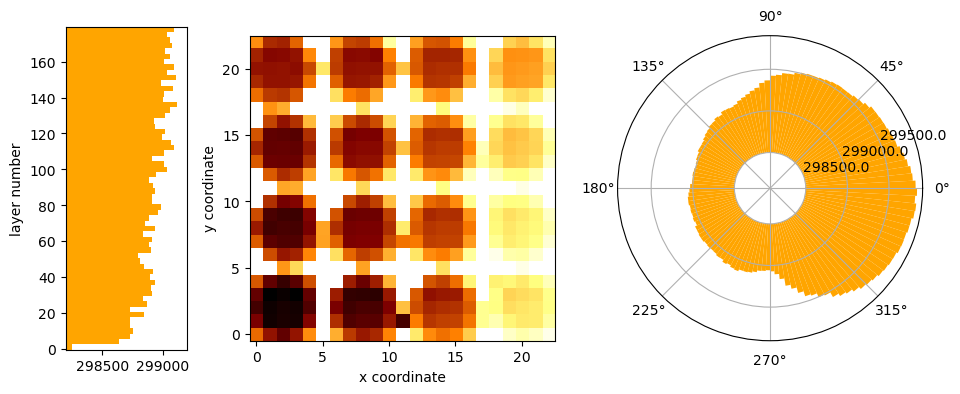

In [10]:
fig = plt.figure(figsize=(9.7,4.0))
plot_health(fig,
            "Photodiode",
            #"Spatter total area",
            XY_hist_22hz,theta_hist_22hz,z_hist_22hz,
            quantity="mean",
            #quantity=lambda hist,ind: hist.sums[ind,:]
            )
fig.tight_layout()

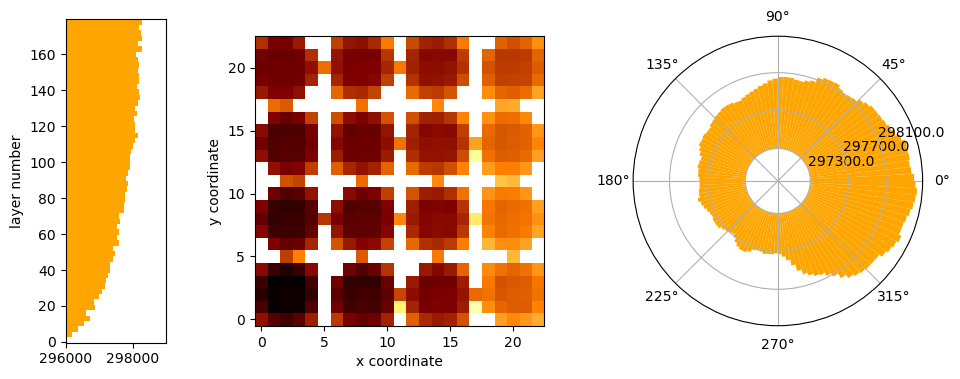

In [11]:
fig = plt.figure(figsize=(9.7,4.0))
plot_health(fig,
            "Photodiode",
            #"Spatter total area",
            XY_hist_30hz,theta_hist_30hz,z_hist_30hz,
            quantity="mean",
            #quantity=lambda hist,ind: hist.sums[ind,:]
            )
fig.tight_layout()